In [1]:
import numpy as np 
import h5py 
import matplotlib.pyplot as plt 
from scipy.special import jn_zeros

In [2]:
a = 6.99e7 # radius (m)
P = 9.925 * 3600 # rotation period (s)
R_dim = a / 2
gamma_dim = 2 * (2 * np.pi / P) / a**2
# Dimensionless parameters
L = 1e7 # m
U = 100 # m/s
T = L / U # s
F = 51.8 # = L**2 / Ld**2
gamma = gamma_dim * L**2 * T
R = R_dim / L

In [3]:
with h5py.File('EVP.h5', 'r') as f:
    print(f["tasks"].keys())
    psi1 = f["tasks/psi1"][:]
    psi2 = f["tasks/psi2"][:]
    evals = f["tasks/evals"][:]
    phi = f["tasks/phi"][:]
    r = f["tasks/r"][:]

print(evals.shape)

<KeysViewHDF5 ['evals', 'phi', 'psi1', 'psi2', 'r']>
(35, 10)


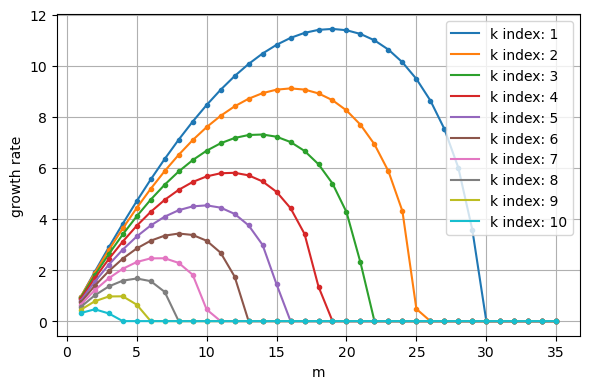

In [4]:
# plot dispersion relation
from scipy.special import jn_zeros
m_range = np.arange(1,36)
plt.figure(figsize=(6,4))
colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
for n_zero in np.arange(1, 11):
    k = np.array([jn_zeros(mi,n_zero)[n_zero-1] / R for mi in m_range])
    a1 = k**4 + 2*F*k**2
    a2 = 2 * ((k**2) + F) * gamma
    a3 = gamma**2 - (k**4) + 2 * F * (k**2)
    c = np.empty(a1.shape + (2,), dtype=np.complex128)
    for i in range(a1.shape[0]):
        c[i, :] = np.roots([a1[i], a2[i], a3[i]])
    s_dedalus = 1j * np.array(evals[:,n_zero-1])
    plt.plot(m_range, s_dedalus.imag, '.', color=colors[n_zero-1])
    plt.plot(m_range, m_range * c[:,0].imag, '-', color=colors[n_zero-1], label=f'k index: {n_zero}')
plt.legend()
plt.grid()
plt.xlabel('m')
plt.ylabel(r'growth rate')
plt.tight_layout()
# plt.savefig('dispersion_relation_imag.pdf')



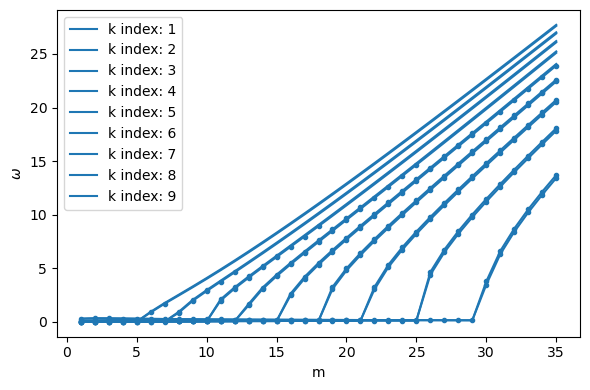

In [5]:
# plot dispersion relation
from scipy.special import jn_zeros
m_range = np.arange(1,36)
plt.figure(figsize=(6,4))
colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
for n_zero in np.arange(1, 10):
    k = np.array([jn_zeros(mi,n_zero)[n_zero-1] / R for mi in m_range])
    a1 = k**4 + 2*F*k**2
    a2 = 2 * ((k**2) + F) * gamma
    a3 = gamma**2 - (k**4) + 2 * F * (k**2)
    c = np.empty(a1.shape + (2,), dtype=np.complex128)
    for i in range(a1.shape[0]):
        c[i, :] = np.roots([a1[i], a2[i], a3[i]])
    s_dedalus = 1j * np.array(evals[:,n_zero-1])
    plt.plot(m_range, np.abs(s_dedalus.real), '.', color='C0')
    plt.plot(m_range, np.abs(m_range * c[:,0].real), '-', color='C0')
    plt.plot(m_range, np.abs(m_range * c[:,1].real), '-', color='C0', label=f'k index: {n_zero}')
    # s_dedalus = 1j * np.array(evals)
    # plt.plot(m_range, s_dedalus.imag, '.', color=colors[n_zero-1])
    # plt.plot(m_range, m_range * c[:,0].imag, '-', color=colors[n_zero-1], label=f'k index: {n_zero}')
plt.legend()
plt.xlabel('m')
plt.ylabel(r'$\omega$')
plt.tight_layout()
# plt.savefig('dispersion_relation_imag.pdf')



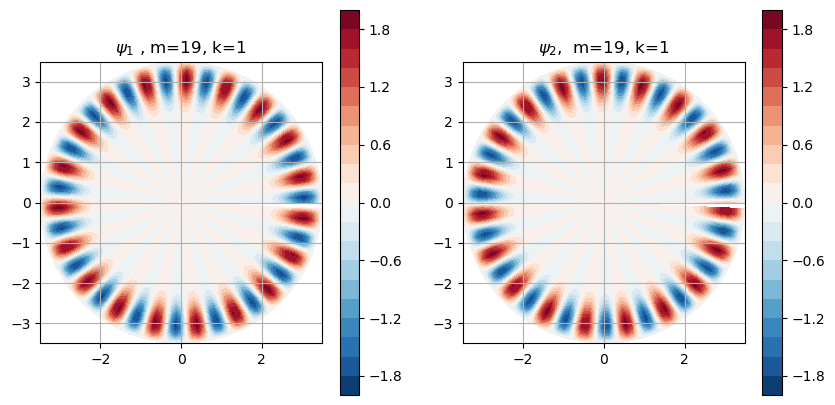

In [6]:
x = r * np.cos(phi)
y = r * np.sin(phi)

m_sel = 19
k_sel = 1
q1t = psi1[m_sel-1,k_sel-1,:,:].real
q2t = psi2[m_sel-1,k_sel-1,:,:].real

fig, ax = plt.subplots(1,2, figsize=(10,5))

im = ax[0].contourf(x,y, q1t, levels=21, cmap='RdBu_r')
ax[0].set_aspect('equal')           # force square aspect
ax[0].set_adjustable('box')         # let the box resize
ax[0].set_title(r'$\psi_1$ ,'+f' m={m_sel}, k={k_sel}')
ax[0].grid()
plt.colorbar(im)

im = ax[1].contourf(x,y, q2t, levels=21, cmap='RdBu_r')
ax[1].set_aspect('equal')           # force square aspect
ax[1].set_adjustable('box')         # let the box resize
ax[1].set_title(r'$\psi_2$, '+f' m={m_sel}, k={k_sel}')
ax[1].grid()
plt.colorbar(im)

plt.show()

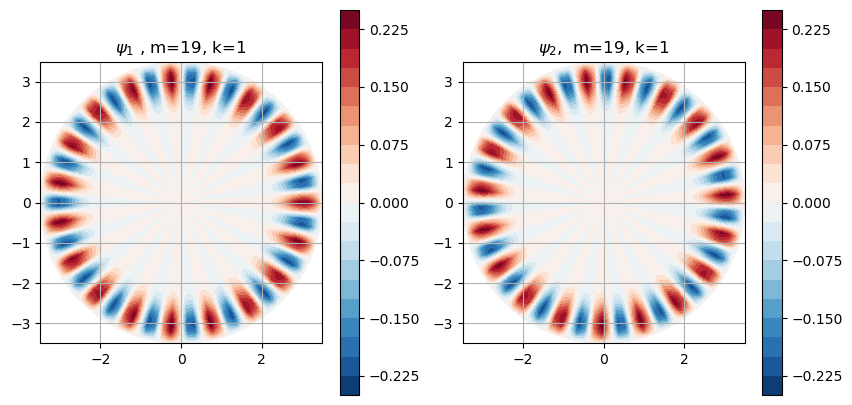

In [10]:
m_sel = 19
k_sel = jn_zeros(m_sel,1) / R 

a1 = k_sel**4 + 2*F*k_sel**2
a2 = 2 * ((k_sel**2) + F) * gamma
a3 = gamma**2 - (k_sel**4) + 2 * F * (k_sel**2)
c = np.roots([a1[0], a2[0], a3[0]])[0]

from scipy.special import jv

nr = 100
nphi = 100

r = np.linspace(0, R, nr)
phi = np.linspace(0, 2*np.pi, nphi)

# 2D grid
R_mesh, PHI_mesh = np.meshgrid(r, phi, indexing='ij')

# Streamfunction mode

psi1 = jv(m_sel, k_sel * R_mesh) * np.exp(1j * m_sel * PHI_mesh)
psi1_real = np.real(psi1)

psi2_coef = ((k_sel**2 + F) * c - k_sel**2 + F + gamma) / F / (c - 1)
# psi2_coef = F * (c -1) / ( (F + k_sel**2)*c - k_sel**2 + F - gamma )
psi2 = psi2_coef * psi1
psi2_real = np.real(psi2)

x = np.reshape(r, (-1,1)) * np.reshape(np.cos(phi), (1,-1))
y = np.reshape(r, (-1,1)) * np.reshape(np.sin(phi), (1,-1))

fig, ax = plt.subplots(1,2, figsize=(10,5))

im = ax[0].contourf(x,y, psi1_real, levels=21, cmap='RdBu_r')
ax[0].set_aspect('equal')           # force square aspect
ax[0].set_adjustable('box')         # let the box resize
ax[0].set_title(r'$\psi_1$ ,'+f' m={m_sel}, k={1}')
ax[0].grid()
plt.colorbar(im)

im = ax[1].contourf(x,y, psi2_real, levels=21, cmap='RdBu_r')
ax[1].set_aspect('equal')           # force square aspect
ax[1].set_adjustable('box')         # let the box resize
ax[1].set_title(r'$\psi_2$, '+f' m={m_sel}, k=1')
ax[1].grid()
plt.colorbar(im)

plt.show()